In [1]:
import pandas as pd
import numpy as np
import math
import random
import os
import matplotlib.pyplot as plt
# import parallel_plume_sim as pps
import multiprocessing
from scipy.interpolate import splprep, splev



##animating
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


## training
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device  # Add this line
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # 1 output (odor)

    def forward(self, x):
        if x.dim() == 3:  # If a batch of sequences is passed in
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        elif x.dim() == 2:  # If a single sequence is passed in
            h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
        else:
            raise ValueError("Unexpected input dimension: %d" % x.dim())
        out, _ = self.lstm(x.unsqueeze(0) if x.dim() == 2 else x, (h0, c0))
        out = self.fc(out.squeeze(0) if x.dim() == 2 else out[:, -1, :])
        return out

    def reset_hidden_state(self, batch_size):
        self.hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device),
                       torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device))

        
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)  # Make LSTM bidirectional
        self.fc = nn.Linear(hidden_size * 2, 1)  # Adjust the input size of the fully connected layer
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        if x.dim() == 3:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)  # Adjust the initial hidden state
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        elif x.dim() == 2:
            h0 = torch.zeros(self.num_layers * 2, 1, self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers * 2, 1, self.hidden_size).to(self.device)
        else:
            raise ValueError("Unexpected input dimension: %d" % x.dim())

        out, _ = self.lstm(x.unsqueeze(0) if x.dim() == 2 else x, (h0, c0))
        out = self.fc(out.squeeze(0) if x.dim() == 2 else out[:, -1, :])
        return out

    def reset_hidden_state(self, batch_size):
        self.hidden = (torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(self.device),
                       torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(self.device))
        
        
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(CNNLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.cnn = nn.Conv1d(input_size, hidden_size, kernel_size=1)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
#         x = x.view(batch_size * seq_length, 1, -1)
        x = x.view(batch_size, seq_length, -1).permute(0, 2, 1)

        x = self.cnn(x)
        x = x.view(batch_size, seq_length, -1)
        out, hidden = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out  # Return only the output


    def reset_hidden_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device))


In [17]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

def load_and_preprocess_file(file_path, features, target):
    # Load the data
    df = pd.read_hdf(file_path)
    df['scaled_odor']=scale_data(df.odor)
    # Scale the features
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Convert data to PyTorch tensors
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)

    # Reshape to (seq_length, n_features)
    feature_tensors = feature_tensors.view(-1, len(features))

    return feature_tensors, target_tensors

def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)


def train_on_single_file(model, optimizer, criterion, sequences, targets, num_epochs, batch_size):
    model.train()
    num_batches = len(sequences) // batch_size  # Determine the number of batches
    
    for epoch in range(num_epochs):
        for batch_idx in range(num_batches):  # Iterate over each batch
            # Get the current batch of sequences and targets
            batch_sequences = sequences[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            batch_targets = targets[batch_idx * batch_size : (batch_idx + 1) * batch_size]

            # Reset the hidden state for each new batch
            model.reset_hidden_state(batch_size)

            # Forward pass
            outputs = model(batch_sequences.view(-1, seq_length, input_size))
            # loss = criterion(outputs[:, -1, :], batch_targets.view(-1, 1))  # Compare only the last prediction with the target
            loss = criterion(outputs[:, -1], batch_targets.view(-1, 1))  # Compare only the last prediction with the target

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 ==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
            
## faster method but needs more gpu power
def train_on_single_file_faster(model, optimizer, criterion, sequences, targets, num_epochs):

    model.train()
    batch_size = sequences.size(0)
    for epoch in range(num_epochs):
        model.reset_hidden_state(batch_size)

        # Forward pass
        outputs = model(sequences.view(-1, seq_length, input_size))
        loss = criterion(outputs, targets.view(-1, 1))  # Compare the output directly with the target

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')




def predict_on_new_data(model, new_data_path, features, target, seq_length, device):
    # Load and preprocess the new data
    feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
    sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)

    # Move sequences to the device
    sequences = sequences.to(device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(sequences.view(-1, seq_length, len(features)))

    # Convert the predictions to a numpy array
    predictions = predictions.cpu().numpy()

    return predictions


In [116]:
features = ['windx', 'windy', 'x', 'y']
target = ['scaled_odor']
seq_length = 10  # Choose a suitable sequence length
num_epochs = 300  # Choose a suitable number of epochs

# Initialize LSTM model
input_size = 4  # Number of features
hidden_size = 128
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
# model = LSTM(input_size, hidden_size, num_layers, device)

In [86]:
model = LSTM(input_size, hidden_size, num_layers, device).to(device)
# model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.007)  # Define your optimizer
criterion = nn.MSELoss()  # Define your loss function


# Iterate over files
filepath="/home/beast/An/data/train/"
for file in os.listdir(filepath):  # Replace with the actual path
    file_path = os.path.join(filepath, file)
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    sequences = sequences.to(device)
    targets = targets.to(device)
    train_on_single_file_faster(model, optimizer, criterion, sequences, targets, num_epochs)
    

#     train_on_single_file(model, optimizer, criterion, sequences, targets, num_epochs, batch_size=32)  # Choose a suitable batch size


Epoch [100/380], Loss: 0.21356788277626038
Epoch [200/380], Loss: 0.21279077231884003
Epoch [300/380], Loss: 0.2100805789232254
Epoch [100/380], Loss: 0.2701745331287384
Epoch [200/380], Loss: 0.270111620426178
Epoch [300/380], Loss: 0.26953282952308655
Epoch [100/380], Loss: 0.6906474828720093
Epoch [200/380], Loss: 0.6895308494567871
Epoch [300/380], Loss: 0.6885921359062195
Epoch [100/380], Loss: 0.40606266260147095
Epoch [200/380], Loss: 0.40560561418533325
Epoch [300/380], Loss: 0.4060337543487549
Epoch [100/380], Loss: 0.29322755336761475
Epoch [200/380], Loss: 0.2918547987937927
Epoch [300/380], Loss: 0.29063037037849426
Epoch [100/380], Loss: 0.2682024836540222
Epoch [200/380], Loss: 0.2658405900001526
Epoch [300/380], Loss: 0.26452258229255676
Epoch [100/380], Loss: 0.20815137028694153
Epoch [200/380], Loss: 0.20878493785858154
Epoch [300/380], Loss: 0.2081996202468872
Epoch [100/380], Loss: 0.42662426829338074
Epoch [200/380], Loss: 0.42399606108665466
Epoch [300/380], Loss: 

In [118]:
# Create three LSTM models
model1 = LSTM(input_size, hidden_size, num_layers, device).to(device)
model2 = LSTM(input_size, hidden_size, num_layers, device).to(device)
model3 = LSTM(input_size, hidden_size, num_layers, device).to(device)

# Create three different optimizers, one for each model
optimizer1 = optim.Adam(model1.parameters(), lr=0.007)  
optimizer2 = optim.Adam(model2.parameters(), lr=0.007)  
optimizer3 = optim.Adam(model3.parameters(), lr=0.007)  

criterion = nn.MSELoss()  # Define your loss function

# Iterate over files
filepath="/home/beast/An/data/train/"
for file in os.listdir(filepath):  # Replace with the actual path
    file_path = os.path.join(filepath, file)
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    sequences = sequences.to(device)
    targets = targets.to(device)
    
    # Train each model on the current file
    train_on_single_file_faster(model1, optimizer1, criterion, sequences, targets, num_epochs)
    train_on_single_file_faster(model2, optimizer2, criterion, sequences, targets, num_epochs)
    train_on_single_file_faster(model3, optimizer3, criterion, sequences, targets, num_epochs)




Epoch [100/300], Loss: 0.211899533867836
Epoch [200/300], Loss: 0.21991066634655
Epoch [300/300], Loss: 0.2103079855442047
Epoch [100/300], Loss: 0.21098116040229797
Epoch [200/300], Loss: 0.2096344232559204
Epoch [300/300], Loss: 0.21279297769069672
Epoch [100/300], Loss: 0.2072601467370987
Epoch [200/300], Loss: 0.21092548966407776
Epoch [300/300], Loss: 0.21205411851406097
Epoch [100/300], Loss: 0.2695223391056061
Epoch [200/300], Loss: 0.2701709270477295
Epoch [300/300], Loss: 0.27138587832450867
Epoch [100/300], Loss: 0.26849108934402466
Epoch [200/300], Loss: 0.26819223165512085
Epoch [300/300], Loss: 0.271135538816452
Epoch [100/300], Loss: 0.26912641525268555
Epoch [200/300], Loss: 0.27030113339424133
Epoch [300/300], Loss: 0.2702178657054901
Epoch [100/300], Loss: 0.6914382576942444
Epoch [200/300], Loss: 0.6913882493972778
Epoch [300/300], Loss: 0.6907739043235779
Epoch [100/300], Loss: 0.6918092966079712
Epoch [200/300], Loss: 0.691409707069397
Epoch [300/300], Loss: 0.69004

Epoch [300/300], Loss: 0.44343453645706177
Epoch [100/300], Loss: 0.4460388720035553
Epoch [200/300], Loss: 0.46131959557533264
Epoch [300/300], Loss: 0.4649519622325897
Epoch [100/300], Loss: 0.22210919857025146
Epoch [200/300], Loss: 0.22906944155693054
Epoch [300/300], Loss: 0.22810840606689453
Epoch [100/300], Loss: 0.22578567266464233
Epoch [200/300], Loss: 0.19857360422611237
Epoch [300/300], Loss: 0.20845606923103333
Epoch [100/300], Loss: 0.2035745084285736
Epoch [200/300], Loss: 0.22775132954120636
Epoch [300/300], Loss: 0.2082623392343521
Epoch [100/300], Loss: 0.38265112042427063
Epoch [200/300], Loss: 0.38265055418014526
Epoch [300/300], Loss: 0.38259878754615784
Epoch [100/300], Loss: 0.38211315870285034
Epoch [200/300], Loss: 0.36515092849731445
Epoch [300/300], Loss: 0.3718964457511902
Epoch [100/300], Loss: 0.34892600774765015
Epoch [200/300], Loss: 0.341579794883728
Epoch [300/300], Loss: 0.3353806436061859
Epoch [100/300], Loss: 0.3654329180717468
Epoch [200/300], Los

Epoch [100/300], Loss: 0.415942519903183
Epoch [200/300], Loss: 0.41549426317214966
Epoch [300/300], Loss: 0.41819000244140625
Epoch [100/300], Loss: 0.4310854971408844
Epoch [200/300], Loss: 0.39839285612106323
Epoch [300/300], Loss: 0.4366641342639923
Epoch [100/300], Loss: 0.4155242443084717
Epoch [200/300], Loss: 0.4235819876194
Epoch [300/300], Loss: 0.39926886558532715
Epoch [100/300], Loss: 0.11337893456220627
Epoch [200/300], Loss: 0.10500428080558777
Epoch [300/300], Loss: 0.04851232469081879
Epoch [100/300], Loss: 0.055554673075675964
Epoch [200/300], Loss: 0.044248566031455994
Epoch [300/300], Loss: 0.08102861791849136
Epoch [100/300], Loss: 0.07068867981433868
Epoch [200/300], Loss: 0.06029985472559929
Epoch [300/300], Loss: 0.059036530554294586
Epoch [100/300], Loss: 0.22576577961444855
Epoch [200/300], Loss: 0.2090175598859787
Epoch [300/300], Loss: 0.21423886716365814
Epoch [100/300], Loss: 0.1453893929719925
Epoch [200/300], Loss: 0.11222852766513824
Epoch [300/300], Lo

In [131]:
# To make predictions, take the average of the predictions from all models
def ensemble_predict(models, data):
    predictions = [model(data) for model in models]
    return torch.mean(torch.stack(predictions), dim=0)

# Make predictions on new data using the ensemble of models
new_data_path = "/home/beast/An/data/test/diag1.h5"
feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
sequences = sequences.to(device)

# Use the ensemble to make predictions
predictions = ensemble_predict([model1, model2, model3], sequences)
pred=predictions.cpu().detach().numpy()
test = pd.read_hdf(new_data_path)

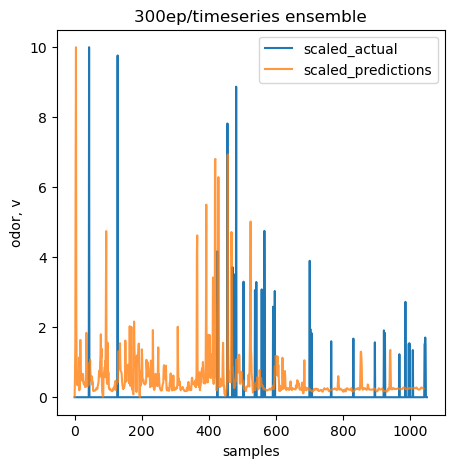

In [132]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(test.scaled_odor, label='scaled_actual')
ax.plot(scale_data_torch(pred), alpha=0.8,label='scaled_predictions')
ax.set_ylabel('odor, v')
ax.set_xlabel('samples')
ax.legend()
ax.set_title('300ep/timeseries ensemble')
f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [97]:
# Save the model weights
torch.save(model.state_dict(), '../assets/modelaug1_380epochs_weights.pth')
# Save the entire model
torch.save(model, '../assets/modelaug1_380epochs.pth')


In [87]:
new_data_path = "/home/beast/An/data/test/diag1.h5"
predictions = predict_on_new_data(model, new_data_path, features, target, seq_length, device)


In [88]:
test = pd.read_hdf(new_data_path)

In [89]:
# snapshot=test[400:600]
# snapshot = snapshot.reset_index(drop=True)
# snapshot

# snapshot.to_hdf('/home/beast/An/data/test/diag_snapshot.h5', key='data', mode='w')

In [108]:
paddedPred=np.pad(predictions, ((37, 0), (0, 0)), 'constant', constant_values=0)

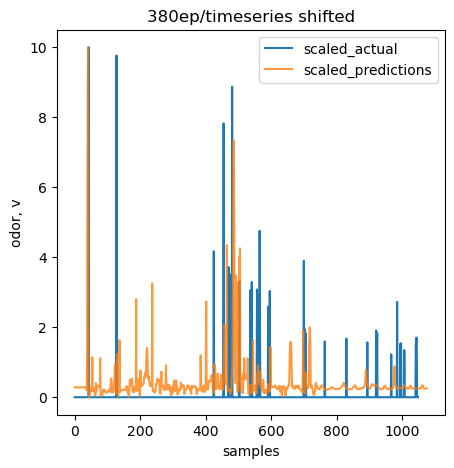

In [113]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(test.scaled_odor, label='scaled_actual')
ax.plot(scale_data(paddedPred), alpha=0.8,label='scaled_predictions')
ax.set_ylabel('odor, v')
ax.set_xlabel('samples')
ax.legend()
ax.set_title('380ep/timeseries shifted')
f.savefig('../assets/380_epochs_full_shifted.jpeg', dpi=150, bbox_inches = "tight")

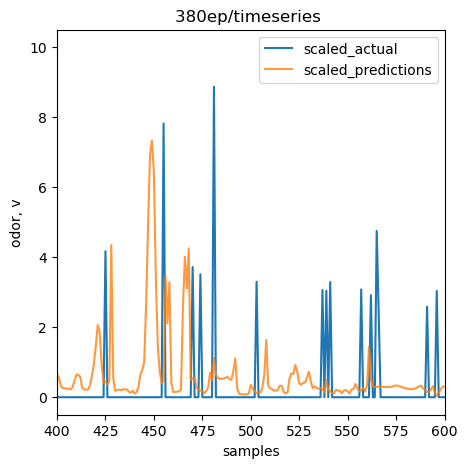

In [115]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(test.scaled_odor, label='scaled_actual')
ax.plot(scale_data(predictions), alpha=0.8,label='scaled_predictions')
ax.set_ylabel('odor, v')
ax.set_xlabel('samples')
ax.legend()
ax.set_title('380ep/timeseries ')
ax.set_xlim(400,600)
f.savefig('../assets/380_epochs_full_zoom.jpeg', dpi=150, bbox_inches = "tight")

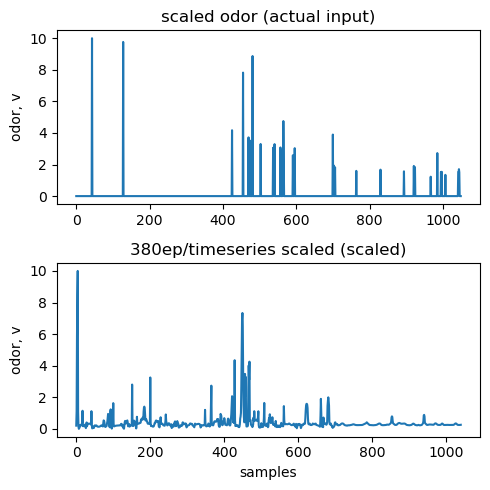

In [105]:
f,ax=plt.subplots(2,1,figsize=(5,5))
ax[0].plot(test.scaled_odor, label='scaled_actual')
ax[1].plot(scale_data(predictions), label='scaled_predictions')
ax[0].set_ylabel('odor, v')
# ax[0].set_xlabel('samples')
ax[1].set_ylabel('odor, v')
ax[1].set_xlabel('samples')
# ax.legend()
ax[0].set_title('scaled odor (actual input)')
ax[1].set_title('380ep/timeseries scaled (scaled)')
f.tight_layout()
f.savefig('../assets/380_epochs_compare2.jpeg', dpi=150, bbox_inches = "tight")